In [1]:
from pathlib import Path
import os

import fastai
from fastai.text.all import *
from fastai.text.core import *

from sklearn.metrics import confusion_matrix

import seaborn as sns

In [2]:
import torch
print(torch.cuda.get_arch_list())

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']


In [3]:
path = Path('/home/khoa-ys/Projects/NLP Project')
data_path = path/'data'
os.listdir(data_path)

['spam_sport.csv',
 'text_sports.csv',
 'Home_and_Kitchen.json',
 'models',
 'spam_sports.csv_tok',
 'spam_sports.csv',
 'Sports_and_Outdoors.csv',
 'Sports_and_Outdoors extra.json',
 'Sports_and_Outdoors extra.csv',
 'Sports_and_Outdoors.json',
 'text_sports_balanced.csv',
 '.ipynb_checkpoints',
 'text_sports_test.csv',
 'spam_sports_test.csv',
 'spam_sports_balanced.csv']

In [4]:
data = pd.read_csv(data_path/'spam_sports.csv')
data

,Processed Text,class
0,might use dirty rust real alice clip appear might use dirty rust likley brand new store correctly per package import vietnam work fine,0.0
1,accurate shot like old school iron site removable good well make easy site shot hasnt lose adjustment two range visit give four star finish difference front rear site really nothing concerned look site extremely accurate,1.0
2,great present niece love ride ride come assembly require really tough great way teach kid ride trike without spending hour lean,1.0
3,great watch nice seiko watch easy read day date hand easy read night comfortable wear,1.0
4,safe wad value price comfortable use wad boot michigan april may steelhead trout fishing temp degree immediately found boot one comfortable boot hike normal fishing run found skagit boot excellent grip surface issue wad flow experienced difficulty brand boot use cleat wad staff flow cf year old fantastic product price would recommend angle friend guide nonguides order another pair maybe pair backup purchase boot amazon com,1.0
...,...,...
17541,reach hard clean spot fabulous brush set get place hand clean real good work super many item,1.0
17542,work great item work great pitcher purchase son much easy manage ice bag,1.0
17543,bad price come one size unfortunately need big water proof water resistant first foray skiing world say ok first hour need dry fire,0.0
17544,five star big well worth money,0.0


<AxesSubplot:>

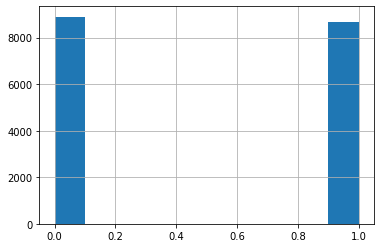

In [5]:
data['class'].hist()

## Language model learner

In [6]:
dls = TextDataLoaders.from_csv(data_path, 'spam_sports.csv', is_lm=True, valid_pct=0.2)
dls.show_batch()

/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future vers

,text,text_
0,xxbos perfect light kettle small pan e use make tea several camp trip perfect light kettle small pan design compact lightweight xxbos great goggles fit head well never fog keep sun eye xxunk speedo make great swim product e use goggles year xxbos five star great knife xxbos four star gift daughter xxbos useless upon reading xxunk review see issue product exclusive one unit purchase first laser site e experience presume something,perfect light kettle small pan e use make tea several camp trip perfect light kettle small pan design compact lightweight xxbos great goggles fit head well never fog keep sun eye xxunk speedo make great swim product e use goggles year xxbos five star great knife xxbos four star gift daughter xxbos useless upon reading xxunk review see issue product exclusive one unit purchase first laser site e experience presume something wrong
1,get high hip suit go right tush e swim xxbos four star low profile bar tape tri bike work expect xxbos decent knife price bad knife complaint almost every buck knife e ever own tend really brittle blade pry twist much blade chip extra hard steel make brittle also make hard sharpen real effective tool e found sharpen buck knife diamond stone pretty sharp box long chip blade hold edge well many,high hip suit go right tush e swim xxbos four star low profile bar tape tri bike work expect xxbos decent knife price bad knife complaint almost every buck knife e ever own tend really brittle blade pry twist much blade chip extra hard steel make brittle also make hard sharpen real effective tool e found sharpen buck knife diamond stone pretty sharp box long chip blade hold edge well many knife
2,want last long sure invest xxunk product sting wax mean difference shot shot xxunk get picture xxbos eyewear case keep safe clean little big real life job well prevent glass get crush dirty especially construction site xxbos devil stick quite easy one rubber coat heavier old one challenge good well make fun start get hang suggest start lighter rubber coat one first xxbos five star work xxbos work apply belt let run,last long sure invest xxunk product sting wax mean difference shot shot xxunk get picture xxbos eyewear case keep safe clean little big real life job well prevent glass get crush dirty especially construction site xxbos devil stick quite easy one rubber coat heavier old one challenge good well make fun start get hang suggest start lighter rubber coat one first xxbos five star work xxbos work apply belt let run slow
3,well price xxbos awesome glove fan xxunk product glove keep loyal customer brand true size feel really great high xxunk xxunk jacket glove yellow stitch match xxbos quality seem decrease seem less protective pad thickness original pair bought year ago yet cost xxbos great item item purchase daughter birthday gift work great beautiful color price great deal xxbos ammo box reloader go wrong mtm box great round reload ready go range xxbos,price xxbos awesome glove fan xxunk product glove keep loyal customer brand true size feel really great high xxunk xxunk jacket glove yellow stitch match xxbos quality seem decrease seem less protective pad thickness original pair bought year ago yet cost xxbos great item item purchase daughter birthday gift work great beautiful color price great deal xxbos ammo box reloader go wrong mtm box great round reload ready go range xxbos emergency
4,instruction type adjustment brake lever front rear derailleurs bike without triathlon handlebar pedal weight lb large handlebar bit wide inch likely cut couple week get use also get ride plastic protector cassette rear wheel cheap design type wheel totally useless well adjust rear derailleur frame seem quality brand price range bottom bracket no - name wheel custom diamondback e no - name name seem good quality hub possible best one market lb,type adjustment brake lever front rear derailleurs bike without triathlon handlebar pedal weight lb large handlebar bit wide inch likely cut couple 

In [7]:
learn = language_model_learner(dls, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path).to_fp16()
learn.fine_tune(180, base_lr=1e-3, freeze_epochs=200)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,9.209138,8.880582,0.012251,7190.973633,00:17
1,9.053329,8.708520,0.012952,6054.275391,00:17
2,8.884828,8.544436,0.013625,5138.083984,00:17
3,8.737133,8.387315,0.014420,4391.011230,00:17
4,8.593966,8.237710,0.015484,3780.872070,00:17
5,8.448705,8.096770,0.016701,3283.844971,00:19
6,8.319017,7.964167,0.017653,2876.031494,00:18
7,8.198909,7.840607,0.018879,2541.746338,00:18
8,8.074323,7.727757,0.020238,2270.503662,00:18
9,7.962685,7.624698,0.021673,2048.161133,00:18


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.358172,6.336350,0.092182,564.731506,00:18
1,5.347726,6.342044,0.092324,567.955933,00:18
2,5.343850,6.345284,0.092599,569.799438,00:18
3,5.342061,6.348155,0.093052,571.437683,00:18
4,5.323143,6.350144,0.093182,572.575073,00:19
5,5.314837,6.351950,0.093254,573.609985,00:18
6,5.315655,6.352571,0.093198,573.966187,00:19
7,5.301092,6.353829,0.093424,574.688904,00:19
8,5.301102,6.355618,0.093413,575.718323,00:18
9,5.301045,6.355748,0.093956,575.792969,00:19


In [11]:
learn.save_encoder('finetuned')

## Text classifier

In [6]:
dls = TextDataLoaders.from_csv(data_path, 'spam_sports.csv', text_col='Processed Text', label_col='class', bs=64, valid_pct=0.3)
dls.show_batch()

/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future vers

,text,category
0,xxbos own one year could give kayak star would careful extensive research various inflatable xxunk sit - on - top kayak available marketplace bought airhead xxunk sometimes list vendor simply airhead xxunk airhead xxunk sit - on - top xxunk inflatable kayak early foremost criterion use xxunk candidate inflatable kayak kayak would need incredibly tough insanely resistant puncture tear damage extreme xxunk one xxunk extreme xxunk plan use rough water fill sharp object well since time past year airhead inflatable kayak subject fairly frequent rough use local river local bay still perfect shape today still use regularly rough water fill sharp object say could give kayak star review would second kayak much mention year old often use rough river water nearby inflatable kayak operate friend almost instantly developed major tear leak sharp object water e sharp rock submerge piece rusty metal submerge rebar stick chunk concrete yet year kayak never,0.0
1,xxbos full mark readability functionality comfort look around lot watch like read lot review buying want good dependable edc every day watch could time run hike help trail general direction less actually order comparable timex expedition trail version watch sent back timex huge hard read look good greenish marking huge black rubber case seem keep come back casio seem get right difference xxunk xxunk v watch xxunk v ask watch near tell except v high - quality nylon wristband v rubberize sport band chose v good experience rubberize wristband comfortable either wore g - shock year eyelet band tore one long slit hold watch well lose ocean nylon v great durable look well rubber wristband comfortable pull arm hair like rubber always watch great readability functionality like second displayed line hour minute eye instantly fall xxunk time xxunk feature make digit shine face make watch extremely readable dark e go,0.0
2,xxbos user review benchmade xxunk update first problem knife one omega spring snap contact company let purchase spring instead send back repair take three four week imagine able repair automobile xxunk firearm instead must go back manufacturer repair people need service plan like still recommend knife like work thing would steer away benchmade knife know policy sell simple part could repair would purchase knife knife use knife everyday cut task performs flawlessly easy xxunk design blade perfect cut task large belly easy spread cut xxunk entire blade edge help maintain cut edge lockup fantastic one hand operation deploy close blade knife well make responds like spring assist knife without risk opening accident pocket dislike knife safety almost assist opener imagine try deploy blade emergency realize safety engage need life select yellow use knife public view almost every day yellow xxunk safety yellow safety xxunk xxunk never deal negative feedback public,0.0
3,xxbos xxunk use torque wrench socket xxunk wrench flat initially socket fit tool measure wrench flat caliper found mm need order cheap mm socket amazon nbsp data - hook product - link - linked class a - link - normal href xxunk -inch - drive - xxunk mm - heavy - duty - xxunk - impact - socket dp b xxunk ref cm cr arp rvw txt ie utf xxunk -inch drive mm heavy duty xxunk impact socket nbsp set one -but go figure get totally confuse work tool get caliper xxunk xxunk think must mis - xxunk first time nope mm -the socket bought must wrong measure -point socket heck finally dawn -this silly tool xxunk wrench flat isi bottom bracket extremely sensitive xxunk correctly tight mess longevity loose might loosen way use tool properly torque wrench need get something else tool waste money need turn around buy nbsp,0.0
4,xxbos stuck like chuck totally regret buying stuck total gym xl use total gym xl lose xxunk support tight budget read review internet sound great homework buying expect totally dissapointed review online read go far say well total gym agree even begin bad starter advertisement listing lie fool believ

In [7]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn = learn.load_encoder('finetuned')
trn_labelcounts = data.groupby(["class"]).size()
trn_label_sum = len(data["class"])
trn_weights = [1 - count/trn_label_sum for count in trn_labelcounts]
trn_weights
class_weights=torch.FloatTensor(trn_weights).cuda()
learn.crit = nn.CrossEntropyLoss(weight=class_weights)
learn.fine_tune(30, base_lr=1e-3, freeze_epochs=50)

epoch,train_loss,valid_loss,accuracy,time
0,0.750167,0.677074,0.576097,00:05
1,0.726520,0.657379,0.607828,00:05
2,0.712074,0.645528,0.623979,00:05
3,0.717748,0.639316,0.618469,00:05
4,0.701385,0.634905,0.627779,00:05
5,0.691936,0.630709,0.626639,00:05
6,0.690473,0.625775,0.631959,00:05
7,0.686293,0.624311,0.636519,00:05
8,0.679148,0.619194,0.638039,00:05
9,0.674795,0.620299,0.631959,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.636137,0.601456,0.661790,00:09
1,0.630076,0.598997,0.665020,00:09
2,0.624863,0.596943,0.669770,00:09
3,0.631958,0.597231,0.668060,00:09
4,0.618477,0.601353,0.668820,00:09
5,0.613409,0.598997,0.669200,00:09
6,0.613058,0.602295,0.671670,00:09
7,0.593743,0.601659,0.675090,00:09
8,0.586498,0.611798,0.670340,00:09
9,0.580789,0.604494,0.673570,00:09


In [8]:
learn.show_results()

/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future vers

,text,category,category_
0,xxbos fantastic item change workout life forever one word fantastic title say item completely change workout life first product lightweight sturdy use couple week problem ever come nicely packed good instruction lot research finally settle item many thanks people write review lead make great decision company also nice website picture xxunk really help make sure product would work treadmill short display treadmill cover control problem dh set treadmill use pivot hook - up work great surfshelf come piece leave one piece attach treadmill time small easy move way usually leave tray attach remove easily strap hold surfshelf computer tightly monitor issue could easily get large laptop would still work also use mouse without much problem generally walk speed mph able surf net type word document use excel send email even type review walk treadmill depend walk run speed may able less whatever want computer workout equipment item buy start look,1.0,1.0
1,xxbos fine precision instrument moment first hold watch hand realize quality timepiece first thing strike large size heavy feel yet despite feel comfortable wrist due fine balance bracelet bracelet end link attach watch case solid rather form sheet metal like find watch price range pin hold bracelet watch xxunk ever see bracelet subsequent link also make solid piece steel fold sheet component feather - edged prevent dig wrist removable link pin unusual machine pin collar design though fiddly remove replace nevertheless ensure pin remain under - flush secure correctly instal bracelet perfectly flush side contact wrist make feel smooth wear clasp high quality fold security buckle deploys satisfy click omega style double button catch security buckle close onto spring pin whose end xxunk thus ensure tight fasten wear use feature add watch quiet wrist faint sound come automatic wind mechanism finally bracelet xxunk clever hidden diver extension allow watch worn,1.0,1.0
2,xxbos tight inch inside pro solid construction lot molle d - rings hook seem tough durable xxunk kid say inch explain use zipper water bottle hold area like pry xxunk jaw loose round bottom cooking cup take measure tape check diameter purchase pack promise hold x water bottle mention hold say bottle xxunk however internals pack closer x due insulation plastic nalgene water bottle fine tight fit try slip stainless steel cooking cup bottom thing xxunk -- bring grease set l xxrep 5 o ng needle - nose plier bought expect room old coleman camp cup stanley camp cook set xxunk design backpacker stainless steel bottle -ounce vertically measure three item stack inch spare -- modify stanley xxunk handle easy removal lid would sit bottom handle would hitch atop xxunk ranger band side cooking cup stanley xxunk nest cup xxunk full water top usually keep three item packed together anyway,0.0,0.0
3,xxbos probably best value l find full - size fold bike get mine end may want ride quite bit review bike least month search reading review visit bike forum size competition decide fold bike would best order bike overall nice value fold bike fit easily trunk car fact carry bike time able take ride want fantastic unwieldy bike rack never seem fit right slip slide car cost quite bit well lot less risk bike steal car work trunk instead visible rack another plus happens rain bike stay dry thing different bike receive compare vendor image tire image knobby mountain bike - type tire mine come hybrid - type arrow tread tire actually prefer trail tend ride ride lot pave trail also mixed - use crush limestone trail hybrid tire actually well us people aware picture also see large image vendor website bike picture paint gloss black bike receive paint flat,1.0,1.0
4,xxbos fold standard phrase industry standard come mind product think classic benchmade reason knife popular well like knife community first let talk benchmade little bit many knife cost would seem like rip understand however buy benchmade knife e pay knife benchmade offe

P = 0.7927644514353126, R = 0.6268656716417911, Acc = 0.6718601558046742, Err = 0.3281398441953259, f = 0.700121548880014


<AxesSubplot:>

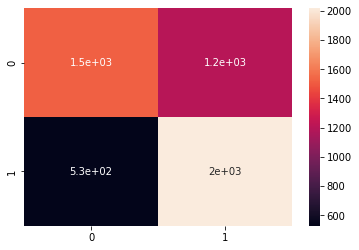

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
TN, FN = interp.confusion_matrix()[0] 
FP, TP = interp.confusion_matrix()[1]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
accuracy = (TP+TN)/(TN+FN+FP+TP)
error = (FP+FN)/(TN+FN+FP+TP)
f_measure = 1/(0.5/precision+0.5/recall)
print("P = {}, R = {}, Acc = {}, Err = {}, f = {}".format(
    precision, recall, accuracy, error, f_measure))
sns.heatmap(interp.confusion_matrix(), annot=True)

In [10]:
interp.plot_top_losses(k=50)

/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/khoa-ys/Projects/NLP Project/venv/lib/python3.8/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future vers

,input,target,predicted,probability,loss
0,xxbos best workout well anything anyway get gazelle edge week ago ok workout anyway movement well none think comment say loose weight use gazelle eat healthier would imagine loose weight eat healthier actually use take minute use even start light sweat construction easy enough skill put thing together take minute total thought one image confuse tell exactly way one wire suppose go get electric monitor accurate thing trust time say calorie burn minute use accurate would best form weight loss around since would high gain low effort workout best state well nothing tip workout different part body feel target part still best use minute day day week start lb see result others state see quality item ok squeak noise lubed happen anymore however grind noise right portion get go away try spray lube take tighten everything still make noise really loud annoy overall give star best workout lot well nothing,0.0,1.0,0.9838834404945374,8.364864349365234
1,xxbos great quality reasonable price synthetic fiber sock oh woman sock many time disappointed many count good sock fit well cool enough warm enough tight loose much synthetic fabric wick away moisture effectively exercise unlike others e try contain cotton also little xxunk structure woven top arch foot keep comfortably snug sock hug foot sock slip slop put stay place day order two set think l buy still available e great everyday wear also good golf sock whose top hit exactly ankle bone highly recommend fit comfort quality yay champion buying right update do purchase two set get update fyi fiber content per xxunk - on label curious mind want know cotton polyester natural latex rubber spandex nylon,0.0,1.0,0.9772113561630249,8.25916576385498
2,xxbos purpose avoid effective exercise people like comfortable possible whenever possible understandable effective exercise issue exercise effective must intense difficult less comfortable usual activity total core serf purpose assist crunch make easy unless really one crunch xxunk purpose help avoid full effort e capable xxunk xxunk work ok decide money spare insist comfortable exercise sofa watch tv buy xxunk actually want work crunch e free,0.0,1.0,0.9817315936088562,8.100112915039062
3,xxbos great gun receive christmas chance take nephew back parent place wood great addition airsoft shotgun plenty powerful accurate definitely use bb make huge difference drawback re - xxunk magazine wish little easy especially run lol otherwise awesome gun,0.0,1.0,0.9794854521751404,7.727539539337158
4,xxbos favorite watch owner watch far favorite citizen watch solid feel watch xxunk point try ton watch stand watch band loose feel favorite band solid feel watch e try would definitely recommend product anybody,0.0,1.0,0.9874640703201294,7.698319435119629
5,xxbos wicked awesome disc wicked awesome disc idea throw disc around much xxunk darn fun fly beautifully feel really comfortable throw catch l probably buy cuz love much,0.0,1.0,0.9782230257987976,7.603971481323242
6,xxbos sturdy tee perfect bought yr old granddaughter happy purchase surprised weight arrive fairly heavy seem stable durable already take bit abuse inexperienced batter hold well far,0.0,1.0,0.9766277074813843,7.561767101287842
7,xxbos great product lot research purchase new treadmill far best xxunk xxunk everyday cardio enjoy xxunk workout sturdy enough jog fee like go fall,0.0,1.0,0.985521137714386,7.37620735168457
8,xxbos great jersey truly great jersey fit perfectly sleeve ride arm rid price amazon unbeatable arrive time perfect chilly winter morning ride,0.0,1.0,0.9883521199226379,7.2573561668396
